In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import datetime
import numpy as np
from shapely import MultiPoint
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
from pyproj import CRS

from utils import add_graticule

Clip Spatial

In [2]:
cycle = 21

kml_file = '/home/jovyan/shared-public/ICESat-2-Hackweek/ground_tracks/cycle%02i_1hz_points.pkl' % cycle
search_file = 'search_circle_ll.geojson'

geo_kml = pd.read_pickle(kml_file)
geo_search = gpd.GeoDataFrame.from_file(search_file)

# Clip gdf 'geo_kml' of kmls with gdf 'geo_search' of AOI (circle polygon)
geo_clipped_df = gpd.clip(geo_kml, geo_search).copy()
geo_clipped_df.sort_values(by='timestamp', inplace=True)
geo_clipped_df.reset_index(inplace=True, drop=True)

In [3]:
# add linestrings to the file
linestrings = geo_clipped_df.groupby(['rgt'])['lat','lon'].apply(lambda x: LineString(list(zip(x.lon.tolist(),x.lat.tolist()))))
times = geo_clipped_df.groupby(by='rgt')['timestamp'].mean()
dflines = gpd.GeoDataFrame(times, geometry=linestrings, crs="EPSG:4326")
dflines['time_str'] = [datetime.datetime.strftime(datetime.datetime.fromtimestamp(t), '%a %Y-%b-%d %H:%M:%S') for t in dflines.timestamp]
dflines.reset_index(inplace=True)

# add the initial search area
geo = geo_search.copy()
geo['rgt'] = 'none'
geo['timestamp'] = 0
geo['time_str'] = 'none'

# put all of the dataframes together
df_out = pd.concat((geo, dflines))
df_out.reset_index(inplace=True, drop=True)
df_out.explore()

/tmp/ipykernel_896/3812668905.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  linestrings = geo_clipped_df.groupby(['rgt'])['lat','lon'].apply(lambda x: LineString(list(zip(x.lon.tolist(),x.lat.tolist()))))


In [4]:
# get the beam pairs
geo_clipped = geo_clipped_df.copy()
crs_lonlat = CRS('epsg:4326')
distances = [-3345, -3255, -45, 45, 3255, 3345]
spots = ['1l', '1r', '2l', '2r', '3l', '3r']

for rgt in np.unique(geo_clipped.rgt):
    
    df_rgt = geo_clipped[geo_clipped.rgt == rgt]
    n_pts = len(df_rgt)
    
    for i in range(n_pts):
        
        # get the locally centered CRS from this point
        thispt = df_rgt.iloc[i]
        cust = CRS("+proj=tmerc +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(thispt.lat, thispt.lon))
        
        # get the surrounding points and transform
        edges = np.clip(np.array([i-1, i+1]), 0, n_pts-1)
        thisdata = df_rgt.iloc[edges[0]:edges[1]+1,:]
        
        xydata = thisdata.to_crs(cust)
        
        dx = xydata.iloc[-1].geometry.x - xydata.iloc[0].geometry.x
        dy = xydata.iloc[-1].geometry.y - xydata.iloc[0].geometry.y
        normal = np.array([-dy, dx])
        unit_normal = normal / np.linalg.norm(normal)
        
        xs, ys = [0.0], [0.0]
        for d in distances:
            xy = d * unit_normal
            xs.append(xy[0])
            ys.append(xy[1])
            
        thisdf = df_rgt.iloc[[i]].to_crs(cust)
        thisdf['geometry'] = MultiPoint(np.transpose(np.array([xs,ys])))
        resultdf = thisdf.to_crs('epsg:4326')
        geo_clipped.loc[thispt.name,'geometry'] = resultdf.iloc[0].geometry

In [6]:
# merge with input data and ground track linestrings
df_ex = pd.concat((df_out, geo_clipped[df_out.keys()]))
filename_out = 'test_beams.geojson'
df_ex.to_file(filename_out, driver="GeoJSON")
df_ex.iloc[1:,:].explore()

In [ ]:
# TODO: make linestrings from all the beam points???
# beam_strings = geo_clipped.groupby(['rgt'])['geometry'].apply(lambda x: LineString(list(zip(x.lon.tolist(),x.lat.tolist()))))

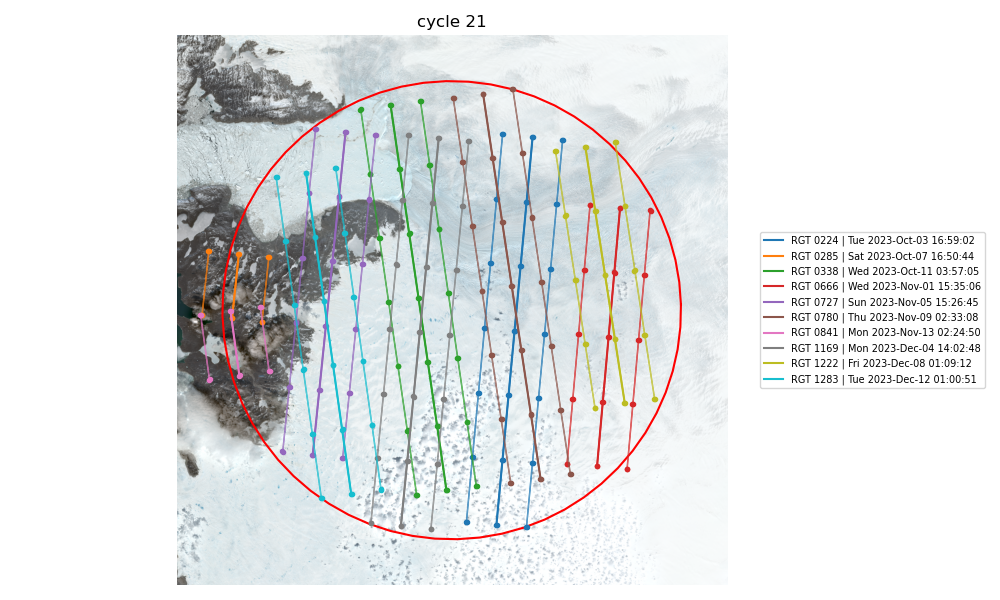

In [11]:
# put the multipoints into data frame columns
spots = ['1l', '1r', '2l', '2r', '3l', '3r']
columns = np.array([[s+'_lon', s+'_lat'] for s in spots]).flatten()
geo_clipped[columns] = np.nan
for i in range(len(geo_clipped)):
    x = geo_clipped.iloc[i]
    pts = np.array([(x.geometry.geoms[j].x, x.geometry.geoms[j].y) for j in range(len(x.geometry.geoms))]).flatten()
    geo_clipped.loc[x.name, columns] = pts[2:]

# plot the example (over a Sentinel-2 mosaic generated over the example area)
imgfn = '/home/jovyan/shared-public/ICESat-2-Hackweek/ground_tracks/s2mosaic.tif'
img = rio.open(imgfn)
fig, ax = plt.subplots(figsize=[10,6])
rioplot.show(img, ax=ax);
crs_plot = img.crs

# plot area of intererst
x, y = df_ex.iloc[0].geometry.exterior.xy
bound_x, bound_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=x,ys=y)
ax.plot(bound_x, bound_y, c="red")

# plot gound tracks and beams
hdls = []
for j, rgt in enumerate(np.unique(geo_clipped.rgt)):
    df_rgt = geo_clipped[geo_clipped.rgt == rgt]
    gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=np.array(df_rgt.lon), ys=np.array(df_rgt.lat))
    hdl, = ax.plot(gtx_x,gtx_y,c='C%i'%j, label='RGT %04i | %s' % (df_rgt.rgt.iloc[0], df_rgt.time_str.iloc[0]))
    hdls.append(hdl)
    for i,s in enumerate(spots):
        gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=np.array(df_rgt['%s_lon'%s]),ys=np.array(df_rgt['%s_lat'%s]))
        ax.plot(gtx_x,gtx_y,marker='o',lw=0.5,ms=3,c='C%i'%j)

# figure adjustment things
xr = np.max(bound_x) - np.min(bound_x)
yr = np.max(bound_y) - np.min(bound_y)
fac = 0.1
ax.set_xlim((np.min(bound_x)-fac*xr, np.max(bound_x)+fac*xr))
ax.set_ylim((np.min(bound_y)-fac*yr, np.max(bound_y)+fac*yr))
ax.axis('off')
ax.legend(handles = hdls, bbox_to_anchor=(1.06, 0.5), loc="center left", borderaxespad=0, fontsize=7)
ax.set_title('cycle %i' % cycle)
fig.tight_layout()

fig.savefig('example_plot.jpg', dpi=600)